<a href="https://colab.research.google.com/github/shishir-sh26/port/blob/main/CNplants_N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# 1. Upload your kaggle.json file when asked
from google.colab import files
print("Please upload your kaggle.json file now...")
files.upload()

# 2. Set up Kaggle folder so the API works
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download the dataset DIRECTLY (Fast!)
print("Downloading dataset... (This skips your local internet)")
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

# 4. Unzip the data
print("Unzipping data... (This might take 1-2 minutes)")
!unzip -q new-plant-diseases-dataset.zip
print("Data is ready!")

Please upload your kaggle.json file now...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 98% 2.66G/2.70G [00:28<00:00, 211MB/s]
100% 2.70G/2.70G [00:28<00:00, 101MB/s]
Unzipping data... (This might take 1-2 minutes)
Data is ready!


✅ Found dataset at: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)
Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.

✅ Saved 'class_indices.json'. Download this later for your app.

Starting Training... (This usually takes 10-15 mins on GPU)
Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 824s 371ms/step - accuracy: 0.7730 - loss: 0.7868 - val_accuracy: 0.9159 - val_loss: 0.2589
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 787s 358ms/step - accuracy: 0.9162 - loss: 0.2477 - val_accuracy: 0.9270 - val_loss: 0.2155
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 801s 364ms/step - accuracy: 0.9259 - loss: 0.2191 - val_accuracy: 0.9249 - val_loss: 0.2188
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 790s 360ms/step - accuracy: 0.9295 - loss: 0.2025 - val_accuracy: 0.9404 - val_loss: 0.1765
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 787s 358ms/step - accuracy: 0.9354 - loss: 0.1900 - val_accuracy: 0.9344 - val_loss: 0.2003



✅ Model saved!


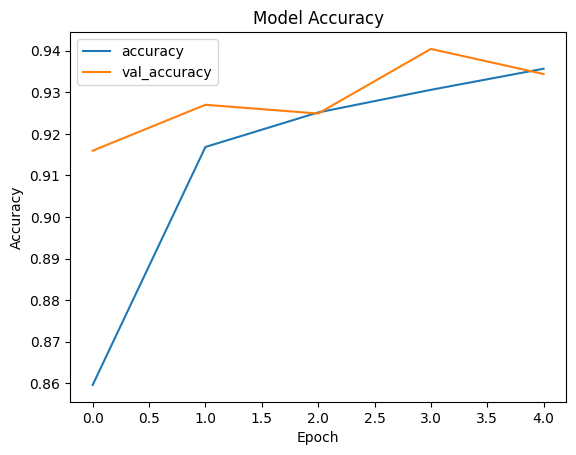

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import json
import os

# ==========================================
# 1. AUTO-DETECT PATHS
# ==========================================
# Colab unzips into the current directory.
# We look for the folder starting with "New Plant" to avoid path errors.
root_path = os.getcwd()
dataset_folder = ""

# Walk through folders to find the 'train' folder automatically
for root, dirs, files in os.walk(root_path):
    if 'train' in dirs:
        dataset_folder = root
        break

if dataset_folder:
    train_dir = os.path.join(dataset_folder, 'train')
    valid_dir = os.path.join(dataset_folder, 'valid')
    print(f"✅ Found dataset at: {dataset_folder}")
else:
    raise ValueError("Could not find the dataset. Did Step 2 finish unzipping?")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ==========================================
# 2. DATA GENERATORS
# ==========================================
# We reduce augmentation slightly to speed up training in Colab
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# SAVE THE LABELS (Crucial for your App)
class_map = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_map, f)
print("\n✅ Saved 'class_indices.json'. Download this later for your app.")

# ==========================================
# 3. BUILD & TRAIN MODEL
# ==========================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_map), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), # Slightly faster learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nStarting Training... (This usually takes 10-15 mins on GPU)")
# TIP: Go to Runtime > Change runtime type > Select T4 GPU for speed
history = model.fit(
    train_generator,
    epochs=5,  # Reduced to 5 for a quick test. Increase to 10-20 for final result.
    validation_data=validation_generator
)

# ==========================================
# 4. DOWNLOAD YOUR MODEL
# ==========================================
model.save('plant_disease_model.h5')
print("\n✅ Model saved!")

# Plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Loading model and labels...


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


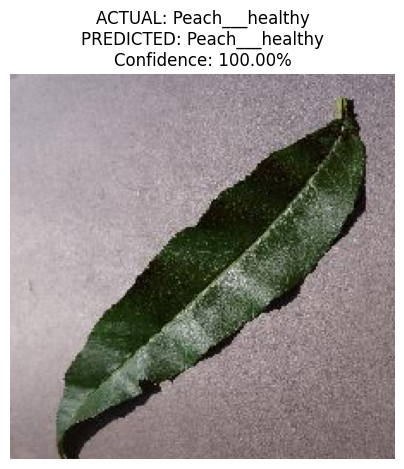

✅ SUCCESS! The model predicted correctly.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import json
import os
import random

# 1. LOAD THE SAVED MODEL & LABELS
print("Loading model and labels...")
model = load_model('plant_disease_model.h5')

with open('class_indices.json', 'r') as f:
    class_map = json.load(f)

# INVERT the map: We have {'Disease': 0}, we need {0: 'Disease'} to read the output
label_map = {v: k for k, v in class_map.items()}

# 2. PICK A RANDOM IMAGE FROM VALIDATION SET
# We find the 'valid' directory dynamically again just to be safe
root_path = os.getcwd()
dataset_folder = ""
for root, dirs, files in os.walk(root_path):
    if 'valid' in dirs:
        dataset_folder = os.path.join(root, 'valid')
        break

# Pick a random disease folder, then a random image inside it
random_class = random.choice(os.listdir(dataset_folder))
random_class_path = os.path.join(dataset_folder, random_class)
random_image_name = random.choice(os.listdir(random_class_path))
img_path = os.path.join(random_class_path, random_image_name)

# 3. PREPROCESS THE IMAGE
# (Must match the training: Resize to 224x224 and divide by 255)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = x / 255.0  # CRITICAL: Normalize pixel values!
x = np.expand_dims(x, axis=0) # Add batch dimension (1, 224, 224, 3)

# 4. PREDICT
predictions = model.predict(x)
predicted_index = np.argmax(predictions) # Get the index of the highest score
predicted_label = label_map[predicted_index]
confidence = np.max(predictions) * 100

# 5. DISPLAY RESULTS
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title(f"ACTUAL: {random_class}\nPREDICTED: {predicted_label}\nConfidence: {confidence:.2f}%")
plt.show()

if random_class == predicted_label:
    print("✅ SUCCESS! The model predicted correctly.")
else:
    print("❌ FAIL. The model made a mistake.")

Upload a plant leaf image:


Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


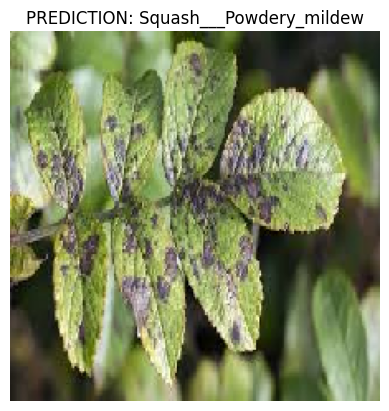

In [5]:
from google.colab import files

# 1. Upload image
print("Upload a plant leaf image:")
uploaded = files.upload()

for filename in uploaded.keys():
    # 2. Load and Process
    path = filename
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # 3. Predict
    predictions = model.predict(x)
    predicted_index = np.argmax(predictions)
    predicted_label = label_map[predicted_index] # Uses the map we created above

    # 4. Show
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"PREDICTION: {predicted_label}")
    plt.show()